<a href="https://colab.research.google.com/github/gigabitamin/colab_task/blob/main/plant_species_search_model_(ac_0_50_loss_1_63)_231229_0609.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 팜 퀘스트 정상 이미지 작물 종 판단 모델링
- 합성곱 신경망 다중 클래스 분류
- 카테고리 6개
- 다중 클래스 분류 모델 생성

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/package'
save_path = '/content/drive/MyDrive/Colab Notebooks/package' ## 패키지가 저장될 경로

os.symlink(save_path, my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [4]:
import numpy as np

import os, glob

# import splitfolders
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split

import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from itertools import islice

# 코랩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor as FT
from torch import LongTensor as LT
from torch.autograd import Variable
from torchvision import models, transforms
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device('cuda:0')



In [5]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.to(device)
print(resnet18_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 구글 코랩으로 진행 시

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks

!unzip -qq "/content/drive/MyDrive/Colab Notebooks/plant.zip"

len(list(glob('content/image/*.jpg')))

# 모델2
- 카테고리 6개로 테스트

In [ ]:
training_datagen = ImageDataGenerator(rescale = 1./255)
training_datagen

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen



- 우리가 사용할 공공 데이터셋의 경우 이미 train / val 로 나누어져 있는 상태 이기에 밑의 split 작업이 필요없음
- 검증용 데이터 따로 만들 필요가 있을 때 추가로 사용

In [ ]:
# train_set_dir =
# train_set_dir
# test_set_dir =
# test_set_dir

# splitfolders.ratio(train_set_dir, output=test_set_dir, seed=1337, ratio=(0.8, 0.2))


In [ ]:
%%time

#이미지 전처리
TRAINING_DIR = r'G:PROJECT\FINAL\DATA\DOWN\식물 병 유발 통합 데이터(1.79TB)\104.식물 병 유발 통합 데이터\01.데이터\1.Training\원천데이터\정상'
TEST_DIR = r'G:\PROJECT\FINAL\DATA\DOWN\식물 병 유발 통합 데이터(1.79TB)\104.식물 병 유발 통합 데이터\01.데이터\2.Validation\원천데이터\정상'

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(64,64),
    class_mode='categorical',
#     shuffle=True,  # 파일을 섞을지 여부
#     subset='training',  # 'training' 또는 'validation'
#     batch_size=1024,
)
train_generator

# 테스트용
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(64,64),
    class_mode='categorical',
#     shuffle=True,
#     subset='validation',
#     batch_size=1024,
)
test_generator


# 파일개수가 너무 방대한 관계로 64x64로 테스트

Found 254574 images belonging to 6 classes.
Found 31821 images belonging to 6 classes.
CPU times: total: 4.23 s
Wall time: 23.5 s


#### Found 254574 images belonging to 6 classes.  
#### Found 31821 images belonging to 6 classes.  

In [ ]:
# # train_generator에서 일부 데이터만 추출

# from itertools import islice

# batch_size = 32

# train_generator = islice(train_generator, 1000 // train_generator.batch_size)
# test_generator = islice(test_generator, 1000 // test_generator.batch_size)

# train_generator
# test_generator

## 모델2 생성
- 최종 출력 6 (작물 6종)

In [ ]:
%%time

epochs = 12

model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
# model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(6, activation='softmax'))

model2.summary()

# 컴파일
model2.compile(loss='categorical_crossentropy',
              optimizer= 'adam', # RMSprop(learning_rate=0.01),
              metrics=['accuracy'])


# 데이터셋을 잘라서 사용, 자른 파일 갯수 확인
train_generator_small = islice(train_generator, 1000 // train_generator.batch_size)
test_generator_small = islice(test_generator, 1000 // test_generator.batch_size)

print(f'트레인 객체의 배치 : {len(train_generator_small)}')
print(f'테스트 객체의 배치: {len(test_generator_small)}')

# next(train_generator_small)은 train_generator_small에서 첫 번째 배치를 추출
batch_size = len(next(train_generator_small)[0])  # 첫 번째 원소는 이미지, 두 번째 원소는 레이블
print("train_generator_small 의 배치 사이즈:", batch_size)


# 훈련 옵션 설정
check_pointer = ModelCheckpoint('plant_species_search_model.keras')
early_stopping_callback = EarlyStopping(patience=2, restore_best_weights=True)


# 학습 : history
history2 = model2.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=1000 // train_generator.batch_size,
                    validation_data=test_generator_small,
                    validation_steps=1000 // test_generator.batch_size,
#                     batch_size=1024,
                    callbacks=[check_pointer, early_stopping_callback],

#                     workers=4,  # 사용할 프로세스 수
#                     use_multiprocessing=True,
#                     max_queue_size=16,  # 데이터 로딩 큐의 최대 크기
                    )

# 평가
loss2, accuracy2 = model2.evaluate(test_generator)
loss2
accuracy2


# CPU times: total:
# Wall time:

# val_accuracy :
# val_loss :


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

0.5006756782531738

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
=================================================================
Total params: 683974 (2.61 MB)
Trainable params: 683974 (2.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/12
31/31 [==============================] - 345s 11s/step - loss: 1.7402 - accuracy: 0.2308 - val_loss: 1.5719 - val_accuracy: 0.3296
Epoch 2/12
31/31 [==============================] - ETA: 0s - loss: 1.4433 - accuracy: 0.4304WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 31 batches). You may need to use the repeat() function when building your dataset.
WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 182s 6s/step - loss: 1.4433 - accuracy: 0.4304
Epoch 3/12
31/31 [==============================] - ETA: 0s - loss: 1.2327 - accuracy: 0.5534WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 183s 6s/step - loss: 1.2327 - accuracy: 0.5534
Epoch 4/12
31/31 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.6442WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 185s 6s/step - loss: 0.9861 - accuracy: 0.6442
Epoch 5/12
31/31 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.6290WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 183s 6s/step - loss: 1.0102 - accuracy: 0.6290
Epoch 6/12
31/31 [==============================] - ETA: 0s - loss: 0.9485 - accuracy: 0.6532WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 187s 6s/step - loss: 0.9485 - accuracy: 0.6532
Epoch 7/12
31/31 [==============================] - ETA: 0s - loss: 0.8797 - accuracy: 0.6835WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 184s 6s/step - loss: 0.8797 - accuracy: 0.6835
Epoch 8/12
31/31 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.7137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 173s 6s/step - loss: 0.7717 - accuracy: 0.7137
Epoch 9/12
31/31 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.6915WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 180s 6s/step - loss: 0.8776 - accuracy: 0.6915
Epoch 10/12
31/31 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.7208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 183s 6s/step - loss: 0.7675 - accuracy: 0.7208
Epoch 11/12
31/31 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7389WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 192s 6s/step - loss: 0.7491 - accuracy: 0.7389
Epoch 12/12
31/31 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.7429WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31/31 [==============================] - 180s 6s/step - loss: 0.6939 - accuracy: 0.7429
995/995 [==============================] - 5483s 6s/step - loss: 1.6327 - accuracy: 0.5007
CPU times: total: 21min 36s
Wall time: 2h 11min 49s
0.5006756782531738

In [ ]:
# # next(train_generator_small)은 train_generator_small에서 첫 번째 배치를 추출

# batch_size = len(next(train_generator_small)[0])  # 첫 번째 원소는 이미지, 두 번째 원소는 레이블
# print("train_generator_small 의 배치 사이즈:", batch_size)

Best epoch: 1
최고 정확도 EPOCH 훈련 데이터 : (1): 0.23084677755832672


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

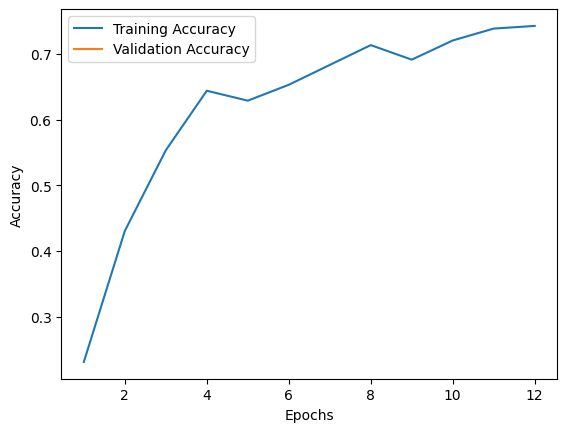

In [ ]:

# 각 epoch에서의 훈련 정확도와 검증 정확도 가져오기
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# 최고 정확도가 나온 epoch 찾기 -> 틀림
# best_epoch = val_accuracy.index(max(val_accuracy)) + 1
# print("Best epoch:", best_epoch)

# 최고 정확도가 나온 epoch의 훈련 데이터 확인 -> 틀림
# best_epoch_train_accuracy = train_accuracy[best_epoch - 1]
# print(f"최고 정확도 EPOCH 훈련 데이터 : ({best_epoch}): {best_epoch_train_accuracy}")

# 훈련 정확도 그래프 출력
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### 테스트 샘플 이미지 전처리

In [ ]:
# categories1 = ['고추', '딸기', '시설포도', '오이', '토마토', '파프리카']
# categories1

In [ ]:
test_samples1 = glob.glob('G:/PROJECT/FINAL/DATA/TEST/plant/test/test-*-' + '*.jpg')
test_samples1

['G:/PROJECT/FINAL/DATA/TEST/plant/test\\test-고추-1.jpg',
 'G:/PROJECT/FINAL/DATA/TEST/plant/test\\test-청포도-3.jpg',
 'G:/PROJECT/FINAL/DATA/TEST/plant/test\\test-포도-2.jpg']

In [ ]:
# 테스트 샘플 이미지 전처리

image_size_x = 64
image_size_y = 64

X_t = []
Y_t = []

# 이미지 전처리
for fname in test_samples1:
    img = Image.open(fname).convert("RGB").resize((image_size_x, image_size_y))
    data = (np.asarray(img).astype('float32')) / 255
    X_t.append(data)
    Y_t.append(fname)

X_t = np.array(X_t)
# X_t

### 예측 및 평가

In [ ]:
# 예측 실행
pred_prob2 = model2.predict(X_t)
pred_prob2[0]

1/1 [==============================] - 0s 352ms/step


array([0.01278567, 0.01427304, 0.18124275, 0.00611078, 0.75813144,
       0.02745621], dtype=float32)

In [ ]:
plant_names = list(train_generator.class_indices.keys())
plant_names

['고추', '딸기', '시설포도', '오이', '토마토', '파프리카']

In [ ]:
test_samples1[0]
test_samples1[0].split('/') # 6

'G:/PROJECT/FINAL/DATA/TEST/plant/test\\test-고추-1.jpg'

['G:', 'PROJECT', 'FINAL', 'DATA', 'TEST', 'plant', 'test\\test-고추-1.jpg']

<Figure size 400x300 with 0 Axes>

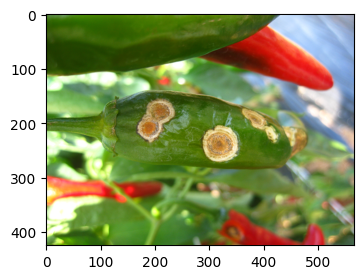

테스트 파일 :  G:/PROJECT/FINAL/DATA/TEST/plant/test\test-고추-1.jpg
실제 :  고추
예측 :  토마토
--> False


<Figure size 400x300 with 0 Axes>

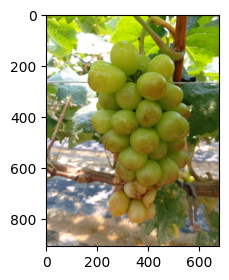

테스트 파일 :  G:/PROJECT/FINAL/DATA/TEST/plant/test\test-청포도-3.jpg
실제 :  청포도
예측 :  파프리카
--> False


<Figure size 400x300 with 0 Axes>

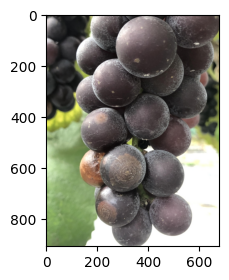

테스트 파일 :  G:/PROJECT/FINAL/DATA/TEST/plant/test\test-포도-2.jpg
실제 :  포도
예측 :  토마토
--> False


In [ ]:


for idx, p in enumerate(pred_prob2):
    plt.figure(figsize=(4, 3))
    plt.imshow(mpimg.imread(test_samples1[idx]))
    plt.show()

    max_idx = p.argmax() # 예측 확률이 가장 큰 값의 인덱스

    real = test_samples1[idx].split('/')[6].split('\\')[1].split('-')[1]\

    print('테스트 파일 : ', test_samples1[idx])
    print('실제 : ', real)
    print('예측 : ', plant_names[max_idx])

    if real == plant_names[max_idx]:
        print('--> True')
    else:
        print('--> False')




### 모델2 그래프

In [ ]:
plt. figure(figsize=(18, 6))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()

# 손실률
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
history2.history.keys()

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

In [ ]:

# 정확도
x_len2 = np.arange(len(loss2))
plt.plot(x_len2, val_loss2, marker='.', c='red', label='Validation loss')
plt.plot(x_len2, loss2, marker='.', c='blue', label='Training loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 예시) epoch 7 부근에서 과적합이 예상된다면 epoch 7로 재학습

### 모델2 재학습
- epoch =

In [ ]:
%%time

epochs = 15

model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
# model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(6, activation='softmax'))

model2.summary()

# 컴파일
model2.compile(loss='categorical_crossentropy',
              optimizer= 'adam', # RMSprop(learning_rate=0.01),
              metrics=['accuracy'])


# 데이터셋을 잘라서 사용, 자른 파일 갯수 확인
train_generator_small = islice(train_generator, 1000 // train_generator.batch_size)
test_generator_small = islice(test_generator, 1000 // test_generator.batch_size)

print(f'트레인 객체의 배치 : {len(train_generator_small)}')
print(f'테스트 객체의 배치: {len(test_generator_small)}')

# next(train_generator_small)은 train_generator_small에서 첫 번째 배치를 추출
batch_size = len(next(train_generator_small)[0])  # 첫 번째 원소는 이미지, 두 번째 원소는 레이블
print("train_generator_small 의 배치 사이즈:", batch_size)


# 훈련 옵션 설정
check_pointer = ModelCheckpoint('plant_species_search_model.keras')
early_stopping_callback = EarlyStopping(patience=2, restore_best_weights=True)


# 학습 : history
history2 = model2.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=1000 // train_generator.batch_size,
                    validation_data=test_generator_small,
                    validation_steps=1000 // test_generator.batch_size,
#                     batch_size=1024,
                    callbacks=[check_pointer, early_stopping_callback],

#                     workers=4,  # 사용할 프로세스 수
#                     use_multiprocessing=True,
#                     max_queue_size=16,  # 데이터 로딩 큐의 최대 크기
                    )

# 평가
loss2, accuracy2 = model2.evaluate(test_generator)
loss2
accuracy2


# CPU times: total:
# Wall time:

# val_accuracy :
# val_loss :


### 모델2 재학습 그래프

In [ ]:
plt. figure(figsize=(18, 6))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history2r.history['accuracy'], label='accuracy')
plt.plot(history2r.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()

# 손실률
plt.subplot(1, 2, 2)
plt.plot(history2r.history['loss'], label='loss')
plt.plot(history2r.history['val_loss'], label='val_loss')
plt.title('loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
acc2r = history2r.history['accuracy']
val_acc2r = history2r.history['val_accuracy']
loss2r = history2r.history['loss']
val_loss2r = history2r.history['val_loss']

# 정확도
x_len2r = np.arange(len(loss2r))
plt.plot(x_len2r, val_loss2r, marker='.', c='red', label='Validation loss')
plt.plot(x_len2r, loss2r, marker='.', c='blue', label='Training loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 모델2 재학습 이미지 예측 테스트

In [ ]:
for idx, p in enumerate(pred_prob2r):
    plt.figure(figsize=(4, 3))
    plt.imshow(mpimg.imread(test_samples1[idx]))
    plt.show()

    max_idx = p.argmax()

    real = test_samples1[idx].split('/')[3].split('\\')[1].split('-')[1]\

    print('테스트 파일 : ', test_samples1[idx])
    print('실제 : ', real)
    print('예측 : ', food_names[max_idx])

    if real == food_names[max_idx]:
        print('--> True')
    else:
        print('--> False')




# 과적합이 예상됐던 구간을 버리고 epochs = 로 재학습한 결과 확인
# True(TP) 비율이 % -> % 로 유의미하게 정확도가 상승했는지
# 전체적인 재학습 결과 확인


In [ ]:
tensorflow


NameError: name 'tensorflow' is not defined